# A Tutorial to Drug Response Prediction using Graph Neural Network

## 1. Introduction to the GDSC Dataset

The **Genomics of Drug Sensitivity in Cancer (GDSC)** project is a comprehensive resource aimed at identifying the molecular characteristics of cancer cells that predict sensitivity to anti-cancer drugs. It integrates drug response data from thousands of cell lines with genomic, transcriptomic, and proteomic features to study the impact of genetic variants on drug sensitivity.
<!-- ![GDSC Project Overview](../Figures/GDSC_project.png) -->
<img src="../Figures/GDSC_project.png" alt="GDSC_project" width="900" height="400">

*Figure 1: Overview of the GDSC project from the paper "A Landscape of Pharmacogenomic Interactions in Cancer" by Iorio et al., published in Cell, Volume 166, Issue 3, pages 740 - 754 (2016).* 

---

#### GDSC1

**GDSC1** represents the initial phase of the GDSC project, with screenings conducted **before 2015**. This dataset includes:

- **970 cancer cell lines**.
- **403 drugs** focused primarily on well-established therapeutic agents.

#### GDSC2

**GDSC2** is the expanded phase of the project, with data generated **after 2015**. It includes:

- **969 cancer cell lines**, with some overlap but also new cell lines not present in GDSC1.
- **297 drugs**, including newer experimental compounds targeting a broader range of cancer pathways.

---

In this notebook, we will focus on **GDSC2**, as it provides more recent and comprehensive data on drug responses across a wider array of compounds, making it suitable for analyzing modern cancer therapies.



In [1]:
import pandas as pd
import os
import pubchempy as pcp
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import *
# Initialize the class with appropriate URLs
processor = GDSCProcessor(
    gdsc_link='https://cog.sanger.ac.uk/cancerrxgene/GDSC_release8.5/GDSC2_fitted_dose_response_27Oct23.xlsx',
    drug_meta_link='https://www.cancerrxgene.org/api/compounds?list=all&export=csv',
    exp_data_link='https://www.cancerrxgene.org/gdsc1000/GDSC1000_WebResources//Data/preprocessed/Cell_line_RMA_proc_basalExp.txt.zip',
    verbose = False,
    data_path = '../Data/'
)

# Run the full process
processor.run()

Drug Meta data already exists
Gene Expression data already exists
Final DataFrame already exists


## 1.1 Drug Response Data

The GDSC dataset provides **IC50** (half maximal inhibitory concentration) values for hundreds of drugs across various cancer cell lines. The **IC50** value represents the concentration of a drug required to inhibit a biological process (such as cell growth) by 50%. Lower IC50 values indicate higher sensitivity of the cell line to the drug.

### Key Aspects of Drug Response Data:
- **IC50 values**: A measure of how effective a drug is at inhibiting cancer cell proliferation.
- **Drug ID**: Each drug is assigned a unique ID in the dataset.
- **COSMIC_ID**: Each cell line is identified by a unique COSMIC ID, which allows for linking the drug response data to other genomic features of the cell line.

The GDSC dataset contains IC50 values for hundreds of drugs tested across over 1,000 cancer cell lines. This information is critical for understanding which cell lines are more sensitive or resistant to particular drugs.

In [2]:
## Check how many unique drugs
num_drugs = len(processor.df['DRUG_ID'].unique())
print(f'There are {num_drugs} drug in GDSC2.') # 295 unique drugs
## Check how many unique cell lines
num_CCLs = len(processor.df['COSMIC_ID'].unique())
print(f'There are {num_CCLs} cancer cell lines in GDSC2.') # 969 unique cell lines

There are 295 drug in GDSC2.
There are 969 cancer cell lines in GDSC2.


## 1.2 Cancer Cell Lines 

Cancer cell lines (CCLs) are used as model systems for studying drug response and genetic features of cancer. The GDSC dataset includes CCLs derived from a variety of cancer types, including breast, lung, colon, and many more. Each CCL has its own set of molecular features, such as gene expression data, mutation status, and copy number variations. In this notebook, we use the RNAseq data, as the omic feature.

### Key Aspects of CCL Data:
- **COSMIC_ID**: A unique identifier for each CCL, provided by the Catalogue of Somatic Mutations in Cancer (COSMIC) database.
- **Gene Expression Profiles**: RNA sequencing data that provides the expression levels of thousands of genes across different CCLs.
<!-- - **Mutation Data**: Information on specific mutations found in each CCL, which may contribute to drug sensitivity or resistance. -->

By linking drug response data to CCL molecular features, we can investigate the relationships between genetic alterations and drug efficacy.


In [3]:
processor.exp_df.head()

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,LINC00526,PPY2,Unnamed: 17730,Unnamed: 17731,KRT18P55,Unnamed: 17733,POLRMTP1,UBL5P2,TBC1D3P5,Unnamed: 17737
683667,7.780713,2.753253,9.960137,4.351073,3.716740,3.222277,8.221606,3.823474,4.756228,5.805642,...,3.347520,3.230713,3.032447,9.040972,3.102091,2.870875,3.169188,9.810430,3.266915,8.452080
684052,7.301344,2.890533,9.922489,4.125088,3.678987,3.096576,3.588391,4.809305,4.951782,5.089165,...,5.054260,3.003521,2.874737,8.532759,3.068187,2.874065,3.135479,9.073222,3.098364,6.824238
684057,8.233101,2.824687,10.015884,4.749715,3.839433,3.142754,5.329830,3.272124,5.538055,6.428482,...,6.261573,3.031862,3.370459,8.930821,3.322455,3.083922,2.813440,8.893197,3.266184,8.758289
684059,8.333466,3.966757,9.793991,3.976923,3.505669,3.079943,3.373640,4.199048,5.794734,5.902391,...,3.885425,2.993918,2.843472,8.246666,3.219777,3.683564,3.033869,8.691401,3.279230,8.236239
684062,8.391341,2.968360,10.260680,4.295875,4.129471,3.318760,7.103957,3.447994,5.988208,6.257495,...,5.584552,2.959515,2.952987,8.625519,3.056066,3.059551,3.127004,9.396462,3.217885,7.248236


### Summary of Cancer Types in GDSC2

After processing the dataset, we identified **31 distinct cancer types** (excluding the `UNCLASSIFIED` category). Each cancer type is associated with a unique number of cell lines, which can be used to analyze drug sensitivity patterns.

In the GDSC2 dataset, there is one category labeled `UNCLASSIFIED`, representing cell lines that do not fall into the predefined cancer types. For this analysis, we have excluded the `UNCLASSIFIED` category and focused on the main cancer types.

In [4]:
cancer_df = processor.df.groupby('TCGA_DESC')['COSMIC_ID'].nunique().reset_index()
cancer_df.set_index('TCGA_DESC', inplace=True)
cancer_df.columns = ['Number of Unique Cell Lines']
cancer_df.sort_values('Number of Unique Cell Lines', ascending=False, inplace=True)
## Drop UNCLASSIFIED and nan in 'TCGA_DESC'
cancer_df = cancer_df[cancer_df.index != 'UNCLASSIFIED'].dropna()
print(f'There are {len(cancer_df)} cancer types and one \'UNCLASSIFIED\' cancer in GDSC2.')

There are 31 cancer types and one 'UNCLASSIFIED' cancer in GDSC2.


### Top 10 Cancer Types by Number of Unique Cell Lines

The table below shows the **top 10 cancer types** with the highest number of unique cell lines in the GDSC2 dataset:

| Cancer Type (TCGA_DESC) | Number of Unique Cell Lines |
|-------------------------|-----------------------------|
| LUAD (Lung Adenocarcinoma)     | 62                          |
| SCLC (Small Cell Lung Cancer)  | 59                          |
| SKCM (Skin Cutaneous Melanoma) | 54                          |
| BRCA (Breast Cancer)           | 51                          |
| COREAD (Colorectal Cancer)     | 46                          |
| HNSC (Head and Neck Cancer)    | 39                          |
| ESCA (Esophageal Cancer)       | 35                          |
| DLBC (Diffuse Large B-Cell Lymphoma) | 34                   |
| GBM (Glioblastoma Multiforme)  | 34                          |
| OV (Ovarian Cancer)            | 34                          |

These cancer types represent the most frequently occurring cancer cell lines in the dataset and provide a broad range of data for drug sensitivity analysis.


In [5]:
print(cancer_df.head(5))

           Number of Unique Cell Lines
TCGA_DESC                             
LUAD                                62
SCLC                                59
SKCM                                54
BRCA                                51
COREAD                              46


## 1.3 Drugs

In addition to drug response data, the GDSC dataset includes information about the drugs themselves. Each drug is characterized by various chemical properties that can be used to predict its effectiveness in inhibiting cancer cell growth.

### Key Aspects of Drug Features:
- **PubChem ID**: A unique identifier for each drug in the PubChem database.
- **SMILES**: A textual representation of the molecular structure of the drug, which can be used to calculate molecular descriptors for quantitative structure-activity relationship (QSAR) modeling.
- **Pathway Information**: Many drugs target specific biological pathways (e.g., PI3K/AKT/mTOR signaling) that are dysregulated in cancer cells. Understanding these pathways helps identify which drugs might be effective against particular cell lines.
<!-- - **Molecular Descriptors**: Features such as molecular weight, LogP (partition coefficient), and hydrogen bond donors/acceptors provide additional information about the chemical properties of each drug. These descriptors can be used to predict drug efficacy. -->

By integrating drug features with cell line molecular data, we can build predictive models for drug response, identify potential biomarkers of sensitivity, and uncover novel therapeutic strategies for cancer treatment.

In [6]:
processor.df['PATHWAY_NAME']

drug_df = processor.df.groupby('PATHWAY_NAME')['DRUG_ID'].nunique().reset_index()
drug_df.set_index('PATHWAY_NAME', inplace=True)
drug_df.columns = ['Number of Unique Drugs']
drug_df.sort_values('Number of Unique Drugs', ascending=False, inplace=True)
drug_df = drug_df[drug_df.index != 'Unclassified'].dropna()
drug_df = drug_df[drug_df.index != 'Other'].dropna()
print(f'There are {len(drug_df)} pathways in GDSC2, one \'Unclassified\', and  one \'Other\' drug target pathway.')

There are 22 pathways in GDSC2, one 'Unclassified', and  one 'Other' drug target pathway.



### Top 10 Drug Target Pathways by Number of Unique Drugs

The table below shows the **top 10 drug target pathways** with the highest number of unique drugs in the GDSC2 dataset:

| Pathway Name                  | Number of Unique Drugs |
|-------------------------------|------------------------|
| PI3K/MTOR signaling            | 27                     |
| Other, kinases                 | 22                     |
| DNA replication                | 21                     |
| ERK MAPK signaling             | 15                     |
| Chromatin histone methylation  | 13                     |
| Apoptosis regulation           | 13                     |
| Cell cycle                     | 13                     |
| Genome integrity               | 13                     |
| RTK signaling                  | 12                     |
| Chromatin other                | 10                     |

These pathways represent the most frequently targeted mechanisms by drugs in the dataset. **PI3K/MTOR signaling** is the most targeted pathway, with 27 unique drugs, followed by **DNA replication** and **ERK MAPK signaling**.

In [7]:
drug_df.head(5)

,Number of Unique Drugs
PATHWAY_NAME,
PI3K/MTOR signaling,27
"Other, kinases",22
DNA replication,21
ERK MAPK signaling,15
Chromatin histone methylation,13


# 2. Deep Learning for Drug Response Predictions

Drug response prediction is a supervised machine learning (ML) problem. ML models learn patterns and relationships that help in predicting how different cancer cell lines will respond to specific drugs.

Deep Learning (DL) techniques have become a powerful tool for predicting drug response in cancer research. By integrating multi-modal data sources, such as genomic features, molecular structure, and drug screening results, DL facilitates more personalized and effective cancer therapies.

### Key Components of DL for Drug Response Prediction:

1. **Feature Representation**:
    - **Drug Features**: Molecular structure information such as SMILES strings can be transformed into numerical representations (e.g., molecular fingerprints or graph-based representations).
    - **Cell Line Features**: Omics features (e.g., gene expression, mutations) of the cancer cell lines are critical inputs.
   
2. **Modeling**:
    - **Drug and Cell Line Encoders**: Feature encoders for drugs and cell lines learn useful embeddings to improve model performance.

3. **Prediction**:
    - The ML model predicts the drug response for a given drug-cell line pair, producing an output such as the IC50 value, which indicates drug efficacy.

In the figure below, we illustrate the common model used for drug response prediction. The model takes drug features and cell line features, processes them through respective encoders, and produces a prediction of drug response (IC50).

<!-- <object data="../Figures/figure_pipeline.pdf" type="application/pdf" width="100%" height="600px">
    <p>Your browser does not support PDF embedding. <a href="../Figures/figure_pipeline.pdf">Download the PDF</a> to view it.</p>
</object> -->

<!-- ![DRP Pipeline](../Figures/DRP_pipeline.png) -->
<img src="../Figures/DRP_pipeline.png" alt="DRP Pipeline" width="900" height="400">

*Figure 2: Machine Learning pipeline for drug response prediction, showing the process of encoding both drug and cell line features for IC50 prediction.*


### Train-Test Split:

- **test_size=0.3**: This specifies that 30% of the data will be used as the test set, while the remaining 70% will be used to train the model.
- **random_state=42**: This ensures the split is reproducible. Using the same random state value guarantees that the data is split in the same way every time the code is run.

By performing this split, we ensure that the model’s performance is evaluated on a separate dataset that was not used during training, giving us a realistic understanding of how well the model can predict drug response for unseen cancer cell lines and drug pairs.

<img src="../Figures/mix_test.png" alt="DRP Pipeline" width="400" height="500">

*Figure 3: Mixed test for the drug response prediction.*

In [323]:
### Normalize the gene expression data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
## apply it to the processor.exp_df
processor.exp_df.iloc[:, :] = scaler.fit_transform(processor.exp_df.values)
cosmics_to_idx = {cosmic_id: idx for idx, cosmic_id in enumerate(processor.exp_df.index)}

## 3. Molecular Structure and Its Influence on Drug Properties 

The structure of a small molecule plays a critical role in determining its chemical and biological properties. In drug discovery and cancer research, molecular structure affects how a drug interacts with its target, its ability to be absorbed, distributed, metabolized, and excreted in the body, as well as its overall efficacy and toxicity. Understanding and visualizing these structures helps researchers predict drug response and optimize therapeutic strategies.

### Why Molecular Structure Matters:

1. **Binding Affinity**: The three-dimensional arrangement of atoms in a molecule determines its ability to bind to specific receptors or enzymes in a biological system. Small changes in the structure can significantly alter the binding affinity, directly influencing the drug’s potency.
  
2. **Solubility and Permeability**: The functional groups and overall geometry of the molecule affect its solubility in water or lipids, which impacts the drug’s absorption and distribution across cell membranes.

3. **Stability and Metabolism**: Structural features determine how easily a drug is metabolized by enzymes in the liver or other tissues. Certain molecular configurations may be more resistant to degradation, resulting in a longer duration of action, while others are quickly broken down and excreted.

4. **Toxicity**: Some structural motifs can lead to unwanted side effects or toxicity. Understanding the structure-property relationship helps in designing safer drugs with fewer side effects.

In cheminformatics, SMILES (Simplified Molecular Input Line Entry System) is a widely used notation for describing the structure of chemical compounds. However, to better understand the structure of a molecule, it can be useful to visualize the molecule as a graph, where atoms are represented as nodes and chemical bonds as edges. 

In this section, we will:

- Convert a SMILES string into a molecular graph using the RDKit library.
- Visualize the molecular graph using the `networkx` library, which is commonly used for graph data.



### Visualizing Molecular Graph from SMILES Using NetworkX Steps Involved:

1. **SMILES to Molecule Conversion**: We will use RDKit to convert a SMILES string into a molecular object. RDKit is a powerful toolkit that provides tools for chemical informatics, including functions to parse SMILES strings.
  
2. **Molecule to Graph**: After converting the SMILES string into a molecular object, we will transform this molecule into a graph. In the graph, each atom will be a node, and each bond will be an edge.

3. **Visualization**: Finally, we will use `networkx` to visualize the graph structure. Each atom will be labeled with its atomic symbol, and edges between atoms will represent the bonds in the molecule.

### Example SMILES String

The SMILES string we will work with in this section is: `C1=C(C(=O)NC(=O)N1)F`, which is the drug **5-Fluorouracil**.


This represents a molecule where sulfur and oxygen atoms form a key part of the structure, along with carbon atoms and single bonds.

By the end of this section, you will have a clear understanding of how to:
- Convert SMILES data to molecular graphs.
- Use RDKit and NetworkX to visualize the resulting structure.



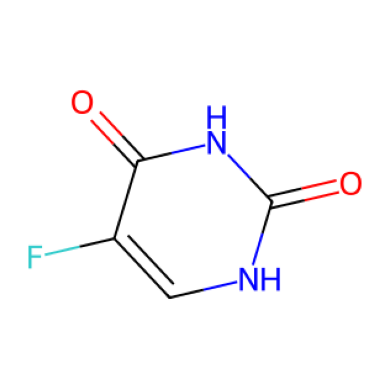

In [8]:
# Import necessary libraries
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

# SMILES string
# smiles = 'O=S(=O)(O)CCS(=O)(=O)O'
smiles = 'C1=C(C(=O)NC(=O)N1)F'
# smiles = 'Brc1ccc(SSc2ccc(Br)cc2)cc1'

# Convert SMILES to a molecule object
molecule = Chem.MolFromSmiles(smiles)

# Check if molecule is valid
if molecule is None:
    print("Invalid SMILES string")
else:
    # Visualize the molecular structure
    img = Draw.MolToImage(molecule, size=(300, 300))

    # Display the molecular graph
    plt.imshow(img)
    plt.axis('off')
    plt.show()


## 2.1 Molecules Graph Representation

In graph-based machine learning, it's common to represent molecules as graphs, where atoms serve as nodes and chemical bonds represent edges. For machine learning tasks, we need a structured format, such as an adjacency matrix to represent the connections between atoms, and node features to describe the properties of each atom. In this section, we will convert a molecule from its SMILES representation into two essential components:

1. **Adjacency Matrix**: A binary matrix that represents the presence or absence of bonds between pairs of atoms.
2. **Node Features**: A feature matrix that describes the atoms in the molecule. In this case, we will use the atomic number (representing the atom type) as the feature for each node.

### Steps Involved:

1. **SMILES to Molecule**: We will begin by converting a SMILES string into a molecular object using the RDKit library. RDKit is highly efficient for parsing chemical data and extracting graph structures from molecules.

2. **Adjacency Matrix**: We will extract the adjacency matrix from the molecule, where the matrix element at position \((i, j)\) indicates whether there is a bond between atom \(i\) and atom \(j\).

3. **Node Features**: For each atom in the molecule, we will extract its atomic number as a simple feature representation. The atomic number corresponds to the type of atom (e.g., Oxygen = 8, Carbon = 6, Sulfur = 16).

### Example SMILES String

In this section, we will use the following SMILES string:  `O=S(=O)(O)CCS(=O)(=O)O`


This molecule contains sulfur (S), oxygen (O), and carbon (C) atoms, and several single and double bonds. By the end of this section, you will be able to:

- Generate an adjacency matrix for the molecular graph.
- Extract the atom types as node features in a NumPy array format.


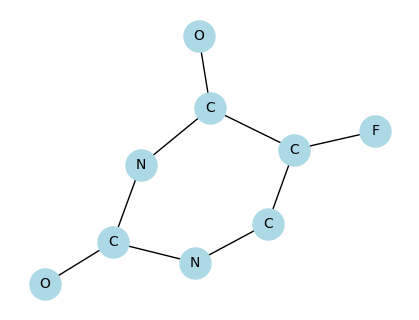

In [9]:
def mol_to_nx(molecule):
    G = nx.Graph()
    
    # Add nodes (atoms)
    for atom in molecule.GetAtoms():
        G.add_node(atom.GetIdx(), label=atom.GetSymbol())
    
    # Add edges (bonds)
    for bond in molecule.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
    
    return G

# Convert molecule to a NetworkX graph
G = mol_to_nx(molecule)

# Get labels for the nodes (atoms)
labels = nx.get_node_attributes(G, 'label')

# Plot the molecular graph using NetworkX
plt.figure(figsize=(4, 3))
pos = nx.spring_layout(G)  # Position the nodes for visualization
nx.draw(G, pos, labels=labels, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
plt.show()

In [10]:
molecule = Chem.MolFromSmiles(smiles)

# Get the number of atoms in the molecule
num_atoms = molecule.GetNumAtoms()

# Initialize the adjacency matrix (num_atoms x num_atoms)
adj_matrix = rdmolops.GetAdjacencyMatrix(molecule)

# Get atom types as node features (atomic numbers and symbols)
atom_types = []
atom_symbols = []
atomic_num_symbol_map = {}

for atom in molecule.GetAtoms():
    atom_num = atom.GetAtomicNum()
    atom_symbol = atom.GetSymbol()
    
    atom_types.append(atom_num)  # Use atomic numbers as node features
    atom_symbols.append(atom_symbol)  # Use atomic symbols as labels
    
    # Map atomic number to symbol if not already in the map
    if atom_num not in atomic_num_symbol_map:
        atomic_num_symbol_map[atom_num] = atom_symbol
print("\nNode Features (Atom Types):")
for i, (atom_num, atom_symbol) in enumerate(zip(atom_types, atom_symbols)):
    print(f"Node {i}: Atomic Number = {atom_num}, Atom Type = {atom_symbol}")
print("\nAdjacency Matrix:")
print(adj_matrix)



Node Features (Atom Types):
Node 0: Atomic Number = 6, Atom Type = C
Node 1: Atomic Number = 6, Atom Type = C
Node 2: Atomic Number = 6, Atom Type = C
Node 3: Atomic Number = 8, Atom Type = O
Node 4: Atomic Number = 7, Atom Type = N
Node 5: Atomic Number = 6, Atom Type = C
Node 6: Atomic Number = 8, Atom Type = O
Node 7: Atomic Number = 7, Atom Type = N
Node 8: Atomic Number = 9, Atom Type = F

Adjacency Matrix:
[[0 1 0 0 0 0 0 1 0]
 [1 0 1 0 0 0 0 0 1]
 [0 1 0 1 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0]
 [0 0 0 0 1 0 1 1 0]
 [0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0]]


### Edge List Representation

In addition to using an adjacency matrix to represent the connections between atoms, another common way to represent graph structures is through an **edge list**. An edge list is a simple way to describe the connections (bonds) in a graph by listing pairs of nodes (atoms) that are connected by edges (bonds).

In the case of molecular graphs:
- **Nodes** represent atoms.
- **Edges** represent the bonds between atoms.

The edge list provides a more compact representation compared to the adjacency matrix, particularly for sparse graphs, where many possible connections do not exist.

### Steps to Create the Edge List:

1. **Extract Bonds from the Molecule**: Using RDKit, we extract the bonds between atoms. Each bond connects two atoms, which we can retrieve as a pair of indices.
  
2. **Build the Edge List**: For each bond in the molecule, we store the indices of the connected atoms as a tuple, creating an undirected edge list. Since chemical bonds are inherently undirected, we avoid adding duplicate edges.

3. **Interpret the Edge List**: Each tuple in the edge list represents a bond between two atoms, identified by their indices in the molecule.



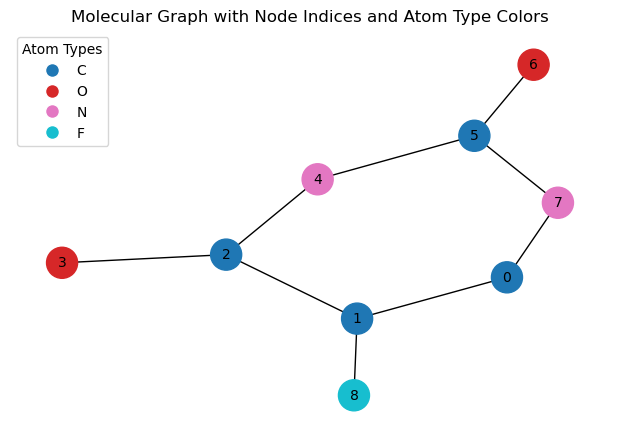


Undirected Edge List:
(0, 1)
(1, 0)
(1, 2)
(2, 1)
(2, 3)
(3, 2)
(2, 4)
(4, 2)
(4, 5)
(5, 4)
(5, 6)
(6, 5)
(5, 7)
(7, 5)
(1, 8)
(8, 1)
(7, 0)
(0, 7)


In [11]:
edge_list = []
for bond in molecule.GetBonds():
    # Each bond connects two atoms (begin atom and end atom)
    atom1 = bond.GetBeginAtomIdx()
    atom2 = bond.GetEndAtomIdx()
    
    # Append both directions of the edge (atom1 -> atom2 and atom2 -> atom1)
    edge_list.append((atom1, atom2))
    edge_list.append((atom2, atom1))  # This ensures the edge is undirected
atom_types, adj_matrix, edge_list, atomic_num_symbol_map = process_molecule(smiles)
visualize_molecule_graph(edge_list, atom_types, atomic_num_symbol_map)
# Print the undirected edge list
print("\nUndirected Edge List:")
for edge in edge_list:
    print(edge)


#### Let's start to process our drug data

In [12]:
drug_smiles_df = processor.drug_meta[['PubCHEM', 'SMILES']]

In [13]:
pubchem_list = []
smiles_list = []
atom_types_list = []
adj_matrix_list = []
edge_list_list = []
atomic_num_symbol_map_list = []
for idx, row in drug_smiles_df.iterrows():
    smiles = row['SMILES']
    pubchem_id = row['PubCHEM']
    atom_types, adj_matrix, edge_list, atomic_num_symbol_map = process_molecule(smiles)
    # Append the results to the respective lists
    pubchem_list.append(pubchem_id)
    smiles_list.append(smiles)
    atom_types_list.append(atom_types)
    adj_matrix_list.append(adj_matrix)
    edge_list_list.append(edge_list)
    atomic_num_symbol_map_list.append(atomic_num_symbol_map)

In [14]:
df_processed = pd.DataFrame({
    'pubchem_id': pubchem_list,
    'smiles': smiles_list,
    'atom_types': atom_types_list,
    'adj_matrix': adj_matrix_list,
    'edge_list': edge_list_list,
    'atomic_num_symbol_map': atomic_num_symbol_map_list
})
df_processed.set_index('pubchem_id', inplace=True)
df_processed.head()

,smiles,atom_types,adj_matrix,edge_list,atomic_num_symbol_map
pubchem_id,,,,,
3385,C1=C(C(=O)NC(=O)N1)F,"[6, 6, 6, 8, 7, 6, 8, 7, 9]","[[0, 1, 0, 0, 0, 0, 0, 1, 0], [1, 0, 1, 0, 0, ...","[(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2...","{6: 'C', 8: 'O', 7: 'N', 9: 'F'}"
11228183,CN(C)CC[C@H](CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O...,"[6, 7, 6, 6, 6, 6, 6, 16, 6, 6, 6, 6, 6, 6, 7,...","[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[(0, 1), (1, 0), (1, 2), (2, 1), (1, 3), (3, 1...","{6: 'C', 7: 'N', 16: 'S', 8: 'O', 17: 'Cl'}"
56645356,CC1=CC=CC=C1C(C(=O)NC2CCCCC2)N(C3=CC(=CC=C3)F)...,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 7, 6, 6, 6, 6, ...","[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2...","{6: 'C', 8: 'O', 7: 'N', 9: 'F'}"
71299339,C1CC1NS(=O)(=O)C2=CC(=C(C=C2)C3=CSC=C3)NC(=O)N...,"[6, 6, 6, 7, 16, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6,...","[[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2...","{6: 'C', 7: 'N', 16: 'S', 8: 'O', 9: 'F'}"
68947304,C[C@@H](C1=C(N=C2C=C(C=CC2=C1)F)C3=CC=CC=N3)NC...,"[6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, ...","[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2...","{6: 'C', 7: 'N', 9: 'F'}"


In [15]:
from torch_geometric.data import Data
pyg_data_dict = {pubchem_id: Data(x=torch.tensor(df_processed.loc[pubchem_id]['atom_types'], dtype=torch.long), edge_index=torch.tensor(df_processed.loc[pubchem_id]['edge_list'], dtype=torch.long).t().contiguous()) for pubchem_id in pubchem_list}
pubchem_id_to_idx = {pubchem_id: idx for idx, pubchem_id in enumerate(pubchem_list)}

In [64]:
# Split the GDSC2 data into train and test sets (70% train, 30% test)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(processor.GDSC2_df, test_size=0.3, random_state=42)

In [17]:
# Display the shapes of the resulting datasets
print(f"Training set size: {train_df.shape}")
print(f"Test set size: {test_df.shape}")

Training set size: (109239, 3)
Test set size: (46817, 3)


### Prepare the Data ready for DL!

We use Pytorch to implement the DL model. The `DrugResponseDataset` class simplifies the process of loading and fetching data required for drug response prediction tasks. It is built to efficiently handle large datasets by precomputing feature tensors for cancer cell lines and drug compounds during initialization. This allows for fast retrieval during training.

### Dataset Inputs:
- **train_df**: A DataFrame containing the **COSMIC_ID**, **PubCHEM_ID**, and **IC50 values** for the drug-cell line pairs.
- **exp_df**: A DataFrame containing the gene expression features for cancer cell lines, indexed by **COSMIC_ID**.
- **pyg_data_dict**: A dictionary containing the drug features, where each drug is represented as a PyTorch Geometric `Data` object, indexed by **PubCHEM_ID**.

### Core Components:

#### 1. Cancer Cell Line Features (`CCL_feature`):
The gene expression data for cancer cell lines is stored as a tensor during initialization. The features are accessed by mapping the **COSMIC_ID** from the training data to the corresponding row in `exp_df`.

#### 2. Drug Features (`drug_feature`):
Drug features are stored as PyTorch Geometric `Data` objects, which are preloaded from the `pyg_data_dict`. Each **PubCHEM_ID** in the training data maps to its corresponding graph-based drug feature.

#### 3. IC50 Values (`IC50_value`):
IC50 values, representing the drug response (inhibition concentration), are stored as tensors. The dataset provides a tensor for each drug-cell line pair, facilitating model training and prediction.


In [19]:
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Batch
class DrugResponseDataset(Dataset):
    def __init__(self, train_df, exp_df, pyg_data_dict):
        """
        Args:
            train_df (DataFrame): DataFrame containing the COSMIC_ID, PubChem_ID, and IC50 values.
            exp_df (DataFrame): DataFrame with the gene expression features for the cancer cell lines (COSMIC_ID).
            pyg_data_dict (dict): Dictionary containing drug features indexed by PubChem_ID.
        """
        # Store the original DataFrames and dictionaries
        self.train_df = train_df
        self.exp_df = exp_df
        self.pyg_data_dict = pyg_data_dict
        
        # Cache dictionaries for efficient access to cell and drug features
        self.cell_feat_cache = {}
        self.drug_feat_cache = {}
        
        # Preprocess IC50 values into tensors
        self.IC50_values = torch.tensor(train_df['LN_IC50'].values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.train_df)
    
    def __getitem__(self, idx):
        """
        Fetches the cancer cell line feature, drug feature, and IC50 value for a given index, with caching to improve efficiency.
        """
        pubchem_id, cosmics_id, IC50_value = self.train_df.iloc[idx]
        
        # Cache cell features
        if cosmics_id not in self.cell_feat_cache:
            cell_feat = self.exp_df.loc[cosmics_id].values
            self.cell_feat_cache[cosmics_id] = torch.tensor(cell_feat, dtype=torch.float32)
        cell_feat = self.cell_feat_cache[cosmics_id]
        
        # Cache drug features
        if pubchem_id not in self.drug_feat_cache:
            drug_feat = self.pyg_data_dict[pubchem_id]
            self.drug_feat_cache[pubchem_id] = drug_feat
        drug_feat = self.drug_feat_cache[pubchem_id]
        
        # Fetch the IC50 value for the current index
        IC50_value = self.IC50_values[idx]
        
        return cell_feat, drug_feat, IC50_value

In [20]:
train_set = DrugResponseDataset(train_df.reset_index(drop=True), processor.exp_df, pyg_data_dict)
test_set = DrugResponseDataset(test_df.reset_index(drop=True), processor.exp_df, pyg_data_dict)

In [21]:
print(f"Training set size: {len(train_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 109239
Test set size: 46817


In [22]:
def _collate_fn(samples):
    CCL_feature, drug_feature, IC50 = map(list, zip(*samples))
    drug_feature = Batch.from_data_list(drug_feature)
    return torch.stack(CCL_feature), drug_feature, torch.stack(IC50)

In [23]:
train_loader = DataLoader(train_set, batch_size=2048, shuffle=True, collate_fn=_collate_fn)
test_loader = DataLoader(test_set, batch_size=2048, shuffle=False, collate_fn=_collate_fn)

In [24]:
next(iter(test_loader))

(tensor([[ 0.1073, -0.3850,  1.3223,  ..., -0.9206, -1.0729,  0.5700],
         [ 0.2518, -0.4235, -0.3957,  ..., -1.4793,  0.9846,  0.4170],
         [-1.7524,  0.3393,  1.1854,  ...,  0.4988,  0.1236,  0.2267],
         ...,
         [ 0.5319, -0.4244, -0.5374,  ...,  0.6452, -0.2039, -0.7114],
         [ 1.1105, -0.6885, -2.0440,  ..., -1.4119,  0.0325,  0.3555],
         [ 1.3439, -0.5785, -0.3055,  ...,  2.9829, -1.7664,  0.6894]]),
 DataBatch(x=[65384], edge_index=[2, 143330], batch=[65384], ptr=[2049]),
 tensor([3.7452, 4.2797, 0.4025,  ..., 2.8231, 1.6904, 7.1776]))

# 4. Introduction to GCN


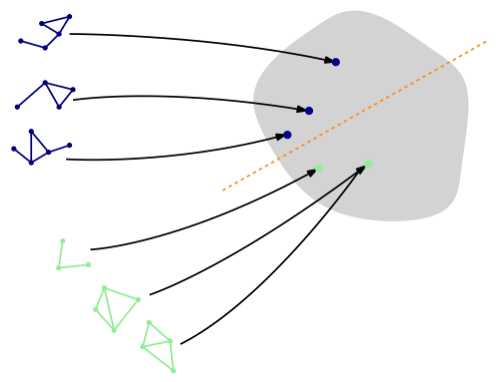


Graph-level supervised learning refers to the problem of classifiying/predicting entire graphs (in contrast to nodes), given a **dataset of graphs**, based on some structural graph properties. Here, we want to embed entire graphs, and we want to embed those graphs in such a way so that they are linearly separable given a task at hand.

**Our goal is to get a 'better vector' (Embedding) of each drug to make the final prediction via the GNN!** 

**Graph Convolutional Networks (GCNs)** are a type of neural network designed to work directly with graph-structured data. Unlike traditional convolutional neural networks (CNNs) that operate on grid-like data (such as images), GCNs are designed to generalize the convolution operation to the graph domain. This makes them powerful tools for tasks such as node classification, graph classification, and link prediction.

The key idea behind GCNs is to aggregate information from a node's neighbors and propagate this information through the network. Each layer of a GCN transforms the node features by combining the features of neighboring nodes, producing richer node representations at each layer. Formally, the graph convolution operation can be written as:

$$
H^{(l+1)} = \sigma(\tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2} H^{(l)} W^{(l)})
$$

Where:

- $\displaystyle H^{(l)}$ is the feature matrix at layer \(l\), of shape [num_node, feature_dim]
- $\displaystyle \tilde{A} = A + I$ is the adjacency matrix with added self-loops,
- $\displaystyle \tilde{D}$ is the degree matrix corresponding to $\tilde{A}$,
- $\displaystyle W^{(l)}$ is the weight matrix at layer \(l\), of shape [feature_dim, feature_dim_next]
- $\displaystyle \sigma$ is an activation function (e.g., ReLU).



In this section, we will build a GCN from scratch using only `NumPy`, following the steps of defining the graph structure, feature matrix, and implementing the graph convolutional layer.

### Step 1: Convert Edge List to Adjacency Matrix and Add Self-Loops

In this step, we will take the undirected `edge_list` and convert it into an adjacency matrix. The adjacency matrix will represent the connections between nodes (atoms in our case). After creating the basic adjacency matrix, we will also add self-loops to ensure each node connects to itself, which is important in GCNs for incorporating the node's own features.

In [315]:
num_nodes = len(atom_types)
adj_matrix = np.zeros((num_nodes, num_nodes))
for edge in edge_list:
    adj_matrix[edge[0], edge[1]] = 1
## Add self-loops
adj_matrix += np.eye(num_nodes)
print("Adjacency Matrix with Self-Loops:")
print(adj_matrix)

Adjacency Matrix with Self-Loops:
[[1. 1. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]]


### Step 2: Normalize the Adjacency Matrix

In this step, we will normalize the adjacency matrix using the degree matrix. Normalization is essential for GCNs to ensure that the information passed between nodes is scaled properly. We use the formula:
$$
\hat{A} = D^{-\frac{1}{2}} A D^{-\frac{1}{2}}
$$
where $\displaystyle A $ is the adjacency matrix, and $\displaystyle D$ is the degree matrix (a diagonal matrix where each entry represents the degree of the corresponding node).


In [316]:
# Normalize the adjacency matrix with the degree matrix
degree_matrix = np.diag(np.sum(adj_matrix, axis=1))
degree_matrix_inv_sqrt = np.linalg.inv(np.sqrt(degree_matrix))  # D^(-1/2)
adj_matrix_normalized = degree_matrix_inv_sqrt @ adj_matrix @ degree_matrix_inv_sqrt  # D^(-1/2) * A * D^(-1/2)
print("Normalized Adjacency Matrix:")
print(adj_matrix_normalized)

Normalized Adjacency Matrix:
[[0.5        0.40824829 0.         ... 0.         0.         0.        ]
 [0.40824829 0.33333333 0.28867513 ... 0.         0.         0.        ]
 [0.         0.28867513 0.25       ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.33333333 0.33333333 0.        ]
 [0.         0.         0.         ... 0.33333333 0.33333333 0.33333333]
 [0.         0.         0.         ... 0.         0.33333333 0.33333333]]


### Step 3: Initialize Random Weights and Prepare Node Features

In this step, we will use the `atom_types` as the node features for the graph. These atomic numbers will be reshaped into a matrix. We will also initialize a random weight matrix for the GCN layer to transform the input features into a higher-dimensional space.


In [318]:
# Initialize the node features as the atomic numbers of the atoms
atom_feature = np.array(atom_types)

# Reshape node features: atomic numbers as 1D features for each node
input_features = atom_feature.reshape(-1, 1)  # Shape: (num_nodes, input_dim=1)

# Define the output dimension of the GCN layer (number of output features per node)
output_dim = 4  # Output dimension of the GCN layer

# Initialize random weights for the GCN layer (shape: input_dim x output_dim)
seed = 42
np.random.seed(seed)
weights = np.random.rand(1, output_dim)  # For simplicity, we use 1D input and 4D output

print("Input Features (Node Features):")
print(input_features.shape)

print("\nRandomly Initialized Weights:")
print(weights)


Input Features (Node Features):
(38, 1)

Randomly Initialized Weights:
[[0.37454012 0.95071431 0.73199394 0.59865848]]


### Step 4: Implementing the GCN Layer

In this step, we define the core operation of the Graph Convolutional Network (GCN) layer. The GCN layer performs two main tasks:

1. **Message Passing**: This involves aggregating the features from a node’s neighbors, which is done by multiplying the normalized adjacency matrix $\displaystyle \hat{A}$ with the feature matrix $\displaystyle X$. This can be expressed as:
   $$
   H = \hat{A} X
   $$
   where:
   - $\displaystyle \hat{A}$ is the normalized adjacency matrix (from Step 3).
   - $\displaystyle X$ is the input feature matrix (from Step 4).

2. **Linear Transformation**: After the message passing step, the GCN applies a linear transformation using a weight matrix $\displaystyle W$. The transformed features are given by:
   $$
   H' = H W = \hat{A} X W
   $$

3. **Activation Function**: To introduce non-linearity, we apply the ReLU (Rectified Linear Unit) activation function, which is defined as:
   $$
   \text{ReLU}(x) = \max(0, x)
   $$
   The final output of the GCN layer is the activated feature matrix.

The function `gcn_layer` implements these operations.


In [319]:
# Define the ReLU function
def ReLU(x: np.ndarray) -> np.ndarray:
    return x * (x > 0)
# Dfine the softmax function
def softmax(x: np.ndarray) -> np.ndarray:
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Stabilize softmax
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def gcn_layer(features, adj_norm, weights):
    # Perform message passing (adjacency matrix * features)
    aggregated_features = adj_norm @ features
    # Apply the weight matrix (linear transformation)
    transformed_features = aggregated_features @ weights
    # Apply an activation function (ReLU)
    activated_features = ReLU(transformed_features)  # ReLU
    return activated_features

In [321]:
gcn_output = gcn_layer(input_features, adj_matrix_normalized, weights)

# Output the GCN-transformed node features
print("GCN Output (Node Features after GCN Layer):")
print(gcn_output.shape)

GCN Output (Node Features after GCN Layer):
(38, 4)


### Step 5: Defining Pooling Functions for Graph-Level Task (Classification/Regression)

In graph classification tasks, we need to aggregate node features into a single graph-level feature vector. This aggregation is achieved through pooling operations. Below are two commonly used pooling methods:

#### 1. Global Mean Pooling

Global mean pooling computes the average of the node features across all nodes:
$$
H_{\text{graph}} = \frac{1}{N} \sum_{i=1}^{N} H_i
$$
where:
- $\displaystyle H_i$ represents the feature vector of the $\displaystyle i$-th node,
- $\displaystyle N$ is the total number of nodes in the graph.

This method effectively summarizes the graph by averaging all node features.

#### 2. Global Max Pooling

Global max pooling takes the maximum value for each feature across all nodes:
$$
H_{\text{graph}} = \max_{i=1}^{N} H_i
$$
This method emphasizes the most important or largest feature values in the graph, which can be useful when only certain nodes dominate the representation.

We can now define these pooling functions to aggregate node features into a single vector suitable for graph-level learning task.


# 5. Graph Neural Network for Drug Response Prediction
Here, we implemented the drug response model GraphDRP developed by Tuan Nguyen et al.

<img src="../Figures/GraphDRP.png" alt="DRP Pipeline" width="800" height="200">

*Figure 3: An illustration of GraphDRP. Graph Convolutional Networks for Drug Response Prediction. IEEE/ACM Trans Comput Biol Bioinform. 2022;19(1):146-154.*

In [322]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool
## Get the max artomic number
max_atom_num = max([max(atom_types) for atom_types in df_processed['atom_types']]) + 1
num_genes = processor.exp_df.shape[1]

In [27]:
from torch_geometric.nn import GINConv, global_add_pool, GCNConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.nn as nn
from torch.nn import Sequential, Linear, ReLU
import torch.nn.functional as F

class GINConvNet(torch.nn.Module):
    def __init__(self, n_output=1,embed_dim=128, embed_output_dim=128, graph_conv = 'GIN'):
        super(GINConvNet, self).__init__()
        dim = embed_dim
        self.relu = nn.ReLU()
        self.n_output = n_output
        self.atom_int_embed_nn = torch.nn.Embedding(max_atom_num, dim)
        # convolution layers
        nn1 = Sequential(Linear(dim,dim), ReLU(), Linear(dim, dim))
        if graph_conv == 'GIN':
            self.conv1 = GINConv(nn1)
        elif graph_conv == 'GCN':
            self.conv1 = GCNConv(dim, dim)
        self.bn1 = torch.nn.BatchNorm1d(dim)

        nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        if graph_conv == 'GIN':
            self.conv2 = GINConv(nn2)
        elif graph_conv == 'GCN':
            self.conv2 = GCNConv(dim, dim)
        self.bn2 = torch.nn.BatchNorm1d(dim)

        nn3 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        if graph_conv == 'GIN':
            self.conv3 = GINConv(nn3)
        elif graph_conv == 'GCN':
            self.conv3 = GCNConv(dim, dim)  
        self.bn3 = torch.nn.BatchNorm1d(dim)

        nn4 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv4 = GINConv(nn4)
        self.bn4 = torch.nn.BatchNorm1d(dim)

        nn5 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, embed_output_dim))
        self.conv5 = GINConv(nn5)
        self.bn5 = torch.nn.BatchNorm1d(dim)
        self.fc1_xd = Linear(dim, embed_output_dim)

        self.cell_line_branch = nn.Sequential(Linear(num_genes, dim), nn.GELU(), Linear(dim, dim))

        # combined layers
        self.fc1 = nn.Linear(2*embed_output_dim, 1024)  # Adjusted input size based on CNN output
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1)

        # activation and regularization
        self.relu = nn.ReLU()

    def forward(self, exp, drug):
        x, edge_index, batch = drug.x, drug.edge_index, drug.batch
        x = self.atom_int_embed_nn(x)
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn3(x)
        x = F.relu(self.conv4(x, edge_index))
        x = self.bn4(x)
        x = F.relu(self.conv5(x, edge_index))
        x = self.bn5(x)
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1_xd(x))

        # RNA-seq input feed-forward:

        # 1d conv layers
        cell_line_features = self.cell_line_branch(exp)
        
        # flatten
        xt = cell_line_features.view(cell_line_features.size(0), -1)
        
        # concat
        combined_features = torch.cat((x, xt), 1)
        # add some dense layers
        x = F.relu(self.fc1(combined_features))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        cell_feat, drug_feat, IC50 = batch[0], batch[1], batch[2]
        cell_feat, drug_feat, IC50 = cell_feat.to(device), drug_feat.to(device), IC50.to(device)
        optimizer.zero_grad()
        outputs = model(cell_feat, drug_feat)
        loss = criterion(outputs, IC50.view(-1, 1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * cell_feat.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

def test(model, test_loader, device):
    model.eval()
    predictions = []
    true_values = []
    with torch.no_grad():
        for batch in test_loader:
            cell_feat, drug_feat, IC50 = batch[0], batch[1], batch[2]
            cell_feat, drug_feat, IC50 = cell_feat.to(device), drug_feat.to(device), IC50.to(device)
            outputs = model(cell_feat, drug_feat)
            predictions.extend(outputs.view(-1).detach().cpu().numpy())
            true_values.extend(IC50.detach().cpu().numpy())
    predictions = np.array(predictions)
    true_values = np.array(true_values)
    return predictions, true_values

def test_metric(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mae = mean_absolute_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)
    pcc, _ = pearsonr(true_values, predictions)
    return rmse, mae, r2, pcc

In [29]:
# device = torch.device('cuda')
# device = 'cpu'
learning_rate = 1e-3
num_epochs = 31
result_df = pd.DataFrame(columns = ['RMSE', 'MAE', 'R2', 'PCC'])

### Next part is for training, while we only show inference the model at the tutorial.

In [36]:
# device = torch.device('cuda')
# for conv_type in ['GIN', 'GCN']:
#     model = GINConvNet(graph_conv=conv_type).to(device)
#                 # Loss and optimizer
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     best_val_rmse = 20
#     best_rmse = 20
#     best_mae = 2
#     best_r2 = -2
#     best_pcc = -2
#     patient = 0
#     best_epoch = 0
        
#     for epoch in range(num_epochs):
#         train_loss = train(model, train_loader, criterion, optimizer, device)
#         print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')
#         if epoch % 5 == 0:
#             predictions, true_values = test(model, test_loader, device)
#             best_rmse, best_mae, best_r2, best_pcc = test_metric(true_values, predictions)
#             print(f'Epoch [{epoch+1}/{num_epochs}], \n'
#                 f'Test RMSE: {best_rmse:.4f}, Test MAE: {best_mae:.4f}, Test R2: {best_r2:.4f}, Test PCC: {best_pcc:.4f}')
#     print("Training completed.")
#     if not os.path.exists('../weights/'):
#         os.makedirs('../weights/')
#     torch.save(model.state_dict(), f'../weights/{conv_type}_model.pth')

Epoch [1/31], Train Loss: 6.3654
Epoch [1/31], 
Test RMSE: 4.1063, Test MAE: 3.4507, Test R2: -1.3279, Test PCC: 0.3095
Epoch [2/31], Train Loss: 1.5174
Epoch [3/31], Train Loss: 1.3086
Epoch [4/31], Train Loss: 1.2136
Epoch [5/31], Train Loss: 1.1263
Epoch [6/31], Train Loss: 1.0345
Epoch [6/31], 
Test RMSE: 1.1066, Test MAE: 0.8559, Test R2: 0.8309, Test PCC: 0.9187
Epoch [7/31], Train Loss: 0.9856
Epoch [8/31], Train Loss: 0.9318
Epoch [9/31], Train Loss: 0.8533
Epoch [10/31], Train Loss: 0.7975
Epoch [11/31], Train Loss: 0.7548
Epoch [11/31], 
Test RMSE: 0.9872, Test MAE: 0.7501, Test R2: 0.8655, Test PCC: 0.9318
Epoch [12/31], Train Loss: 0.7094
Epoch [13/31], Train Loss: 0.6715
Epoch [14/31], Train Loss: 0.6218
Epoch [15/31], Train Loss: 0.5928
Epoch [16/31], Train Loss: 0.5507
Epoch [16/31], 
Test RMSE: 0.9631, Test MAE: 0.7258, Test R2: 0.8719, Test PCC: 0.9340
Epoch [17/31], Train Loss: 0.5342
Epoch [18/31], Train Loss: 0.5142
Epoch [19/31], Train Loss: 0.4726
Epoch [20/31], T

In [35]:
device = 'cpu'
model_GIN = GINConvNet(graph_conv='GIN')
model_GCN = GINConvNet(graph_conv='GCN')
## Load the weight from gpu to cpu
model_GIN.load_state_dict(torch.load('../weights/GIN_model.pth', map_location=torch.device('cpu'), weights_only = False))
model_GCN.load_state_dict(torch.load('../weights/GCN_model.pth', map_location=torch.device('cpu'), weights_only = False))

<All keys matched successfully>

In [47]:
predictions, true_values = test(model_GIN, test_loader, device)
predictions_GCN, true_values_GCN = test(model_GCN, test_loader, device)

In [102]:
rmse, mae, r2, pcc = test_metric(true_values, predictions)
rmse_GCN, mae_GCN, r2_GCN, pcc_GCN = test_metric(true_values_GCN, predictions_GCN)

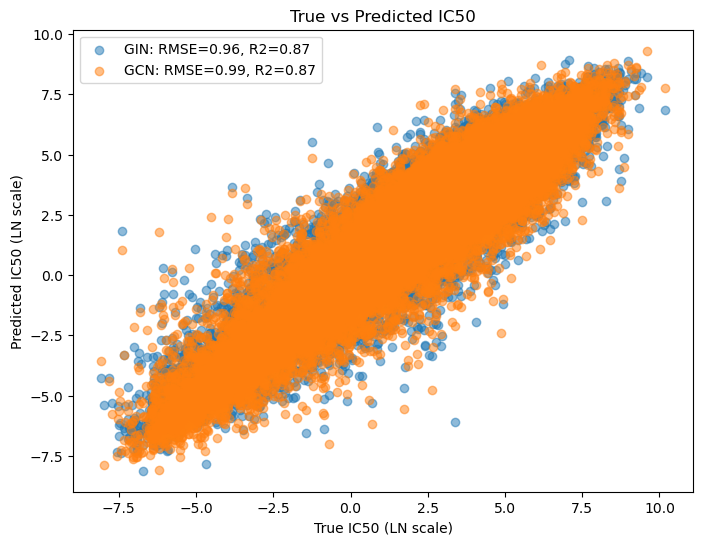

In [103]:
## Scatter plot for the prediction
plt.figure(figsize=(8, 6))
plt.scatter(test_df['LN_IC50'], test_df['Predicted IC50 GIN'], alpha=0.5, label=f'GIN: RMSE={rmse:.2f}, R2={r2:.2f}')
plt.scatter(test_df['LN_IC50'], test_df['Predicted IC50 GCN'], alpha=0.5, label=f'GCN: RMSE={rmse_GCN:.2f}, R2={r2_GCN:.2f}')
plt.xlabel('True IC50 (LN scale)')
plt.ylabel('Predicted IC50 (LN scale)')
plt.title('True vs Predicted IC50')
plt.legend()
plt.show()

In [65]:
## Conver the prediction back to the dataframe
test_df['Predicted IC50 GIN'] = predictions
test_df['Predicted IC50 GCN'] = predictions_GCN

In [66]:
cancer_meta_df = processor.df[['COSMIC_ID', 'TCGA_DESC']].drop_duplicates()
drug_meta_df = processor.drug_meta[['PubCHEM', 'Target pathway']]
test_df = cancer_meta_df.merge(test_df, on='COSMIC_ID')
test_df = test_df.merge(drug_meta_df, on='PubCHEM')

In [76]:
## Check how many TCGA_DESC in the test_df
num_cancer = len(test_df['TCGA_DESC'].unique())

In [109]:
## Get the RMSE for each cancer type
def get_per_cancer_df(pred_col = 'Predicted IC50 GIN'):
    result_df = pd.DataFrame(columns = ['RMSE', 'MAE', 'R2', 'PCC'])
    for cancer in test_df['TCGA_DESC'].unique():
        ## Ignore the nan in 'TCGA_DESC'
        if pd.isnull(cancer):
            continue
        cancer_df = test_df[test_df['TCGA_DESC'] == cancer]
        rmse = np.sqrt(mean_squared_error(cancer_df['LN_IC50'], cancer_df[pred_col]))
        mae = mean_absolute_error(cancer_df['LN_IC50'], cancer_df[pred_col])
        r2 = r2_score(cancer_df['LN_IC50'], cancer_df[pred_col])
        pcc, _ = pearsonr(cancer_df['LN_IC50'], cancer_df[pred_col])
        result_df.loc[cancer, 'RMSE'] = rmse
        result_df.loc[cancer, 'MAE'] = mae
        result_df.loc[cancer, 'R2'] = r2
        result_df.loc[cancer, 'PCC'] = pcc
    return result_df

In [124]:
def get_per_pathway_df(pred_col = 'Predicted IC50 GIN'):
    result_df = pd.DataFrame(columns = ['RMSE', 'MAE', 'R2', 'PCC'])
    for cancer in test_df['Target pathway'].unique():
        ## Ignore the nan in 'TCGA_DESC'
        if pd.isnull(cancer):
            continue
        cancer_df = test_df[test_df['Target pathway'] == cancer]
        rmse = np.sqrt(mean_squared_error(cancer_df['LN_IC50'], cancer_df[pred_col]))
        mae = mean_absolute_error(cancer_df['LN_IC50'], cancer_df[pred_col])
        r2 = r2_score(cancer_df['LN_IC50'], cancer_df[pred_col])
        pcc, _ = pearsonr(cancer_df['LN_IC50'], cancer_df[pred_col])
        result_df.loc[cancer, 'RMSE'] = rmse
        result_df.loc[cancer, 'MAE'] = mae
        result_df.loc[cancer, 'R2'] = r2
        result_df.loc[cancer, 'PCC'] = pcc
    return result_df

In [128]:
def get_per_drug_df(pred_col = 'Predicted IC50 GIN'):
    result_df = pd.DataFrame(columns = ['RMSE', 'MAE', 'R2', 'PCC'])
    for cancer in test_df['PubCHEM'].unique():
        ## Ignore the nan in 'TCGA_DESC'
        if pd.isnull(cancer):
            continue
        cancer_df = test_df[test_df['PubCHEM'] == cancer]
        rmse = np.sqrt(mean_squared_error(cancer_df['LN_IC50'], cancer_df[pred_col]))
        mae = mean_absolute_error(cancer_df['LN_IC50'], cancer_df[pred_col])
        r2 = r2_score(cancer_df['LN_IC50'], cancer_df[pred_col])
        pcc, _ = pearsonr(cancer_df['LN_IC50'], cancer_df[pred_col])
        result_df.loc[cancer, 'RMSE'] = rmse
        result_df.loc[cancer, 'MAE'] = mae
        result_df.loc[cancer, 'R2'] = r2
        result_df.loc[cancer, 'PCC'] = pcc
    return result_df

### Lets visualize the best/worst predicted results among the cancer types.

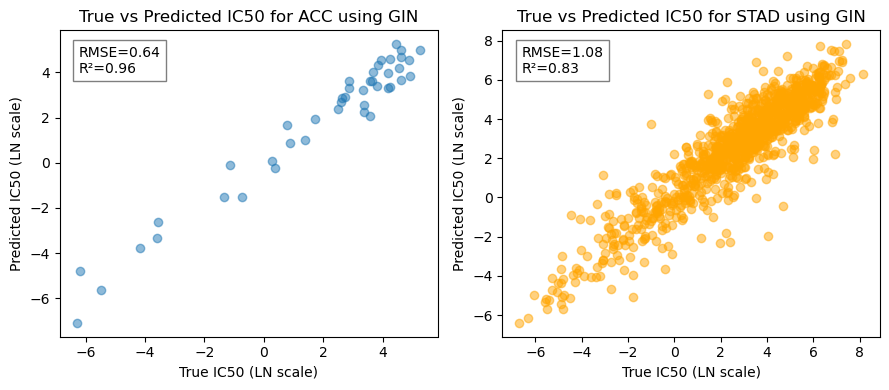

In [160]:
result_df = get_per_cancer_df(pred_col = 'Predicted IC50 GIN')
cancer_type_1 = 'ACC'
cancer_type_2 = 'STAD'

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

# Subplot 1: True vs Predicted IC50 for ACC
sub_df_1 = test_df[test_df['TCGA_DESC'] == cancer_type_1]
ax1.scatter(sub_df_1['LN_IC50'], sub_df_1['Predicted IC50 GIN'], alpha=0.5, label=f'RMSE={result_df.loc[cancer_type_1, "RMSE"]:.2f} \n R2={result_df.loc[cancer_type_1, "R2"]:.2f}')
ax1.set_xlabel('True IC50 (LN scale)')
ax1.set_ylabel('Predicted IC50 (LN scale)')
ax1.set_title(f'True vs Predicted IC50 for {cancer_type_1} using GIN')
ax1.text(0.05, 0.95, f'RMSE={result_df.loc[cancer_type_1, "RMSE"]:.2f}\nR²={result_df.loc[cancer_type_1, "R2"]:.2f}',
         transform=ax1.transAxes, verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# Subplot 2: True vs Predicted IC50 for STAD
sub_df_2 = test_df[test_df['TCGA_DESC'] == cancer_type_2]
ax2.scatter(sub_df_2['LN_IC50'], sub_df_2['Predicted IC50 GIN'], alpha=0.5, color='orange')
ax2.set_xlabel('True IC50 (LN scale)')
ax2.set_ylabel('Predicted IC50 (LN scale)')
ax2.set_title(f'True vs Predicted IC50 for {cancer_type_2} using GIN')
ax2.text(0.05, 0.95, f'RMSE={result_df.loc[cancer_type_2, "RMSE"]:.2f}\nR²={result_df.loc[cancer_type_2, "R2"]:.2f}',
         transform=ax2.transAxes, verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
# Adjust the layout
plt.tight_layout()
plt.show()

### What about the drugs?

In [166]:
drug_result_df = get_per_drug_df(pred_col = 'Predicted IC50 GIN')
drug_result_df.sort_values('RMSE', ascending=False, inplace=True)

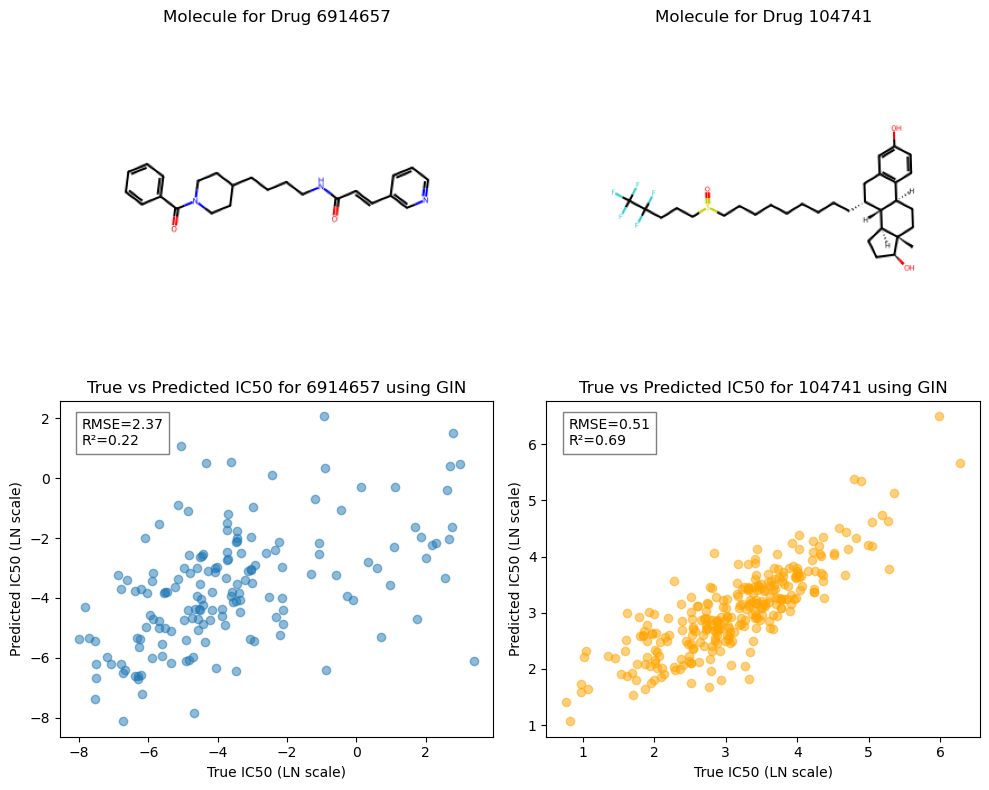

In [204]:
## Visualize the RMSE for each drug
drug_1 = 6914657
drug_2 = 104741

# Create a figure with 1 row and 2 columns
fig, ((ax3, ax4), (ax1, ax2)) = plt.subplots(2, 2, figsize=(10, 8))

# Subplot 1: True vs Predicted IC50 for ACC
sub_df_1 = test_df[test_df['PubCHEM'] == drug_1]
ax1.scatter(sub_df_1['LN_IC50'], sub_df_1['Predicted IC50 GIN'], alpha=0.5, label=f'RMSE={drug_result_df.loc[drug_1, "RMSE"]:.2f} \n R2={drug_result_df.loc[drug_1, "R2"]:.2f}')
ax1.set_xlabel('True IC50 (LN scale)')
ax1.set_ylabel('Predicted IC50 (LN scale)')
ax1.set_title(f'True vs Predicted IC50 for {drug_1} using GIN')
ax1.text(0.05, 0.95, f'RMSE={drug_result_df.loc[drug_1, "RMSE"]:.2f}\nR²={drug_result_df.loc[drug_1, "R2"]:.2f}',
         transform=ax1.transAxes, verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# Subplot 2: True vs Predicted IC50 for STAD
sub_df_2 = test_df[test_df['PubCHEM'] == drug_2]
ax2.scatter(sub_df_2['LN_IC50'], sub_df_2['Predicted IC50 GIN'], alpha=0.5, color='orange')
ax2.set_xlabel('True IC50 (LN scale)')
ax2.set_ylabel('Predicted IC50 (LN scale)')
ax2.set_title(f'True vs Predicted IC50 for {drug_2} using GIN')
ax2.text(0.05, 0.95, f'RMSE={drug_result_df.loc[drug_2, "RMSE"]:.2f}\nR²={drug_result_df.loc[drug_2, "R2"]:.2f}',
         transform=ax2.transAxes, verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
# Adjust the layout

drug_1_smiles = drug_smiles_df[drug_smiles_df.PubCHEM == drug_1].SMILES.values[0]
drug_2_smiles = drug_smiles_df[drug_smiles_df.PubCHEM == drug_2].SMILES.values[0]
molecule = Chem.MolFromSmiles(drug_1_smiles)
# Check if molecule is valid
if molecule is None:
    print("Invalid SMILES string")
else:
    # Visualize the molecular structure
    img = Draw.MolToImage(molecule)
    ax3.set_title(f'Molecule for Drug {drug_1}')
    # Display the molecular graph
    ax3.imshow(img)
    ax3.axis('off')
    # ax1.show()
    img2 = Draw.MolToImage(Chem.MolFromSmiles(drug_2_smiles), size=(300, 300))
    ax4.set_title(f'Molecule for Drug {drug_2}')
    ax4.imshow(img2)
    ax4.axis('off')
    

plt.tight_layout()
plt.show()

### Let's compare the results with the linear regression for the best and worst drug

In [237]:
## Train the Lasso-regression model
from sklearn.linear_model import Lasso
linear_result_df = pd.DataFrame(columns = ['RMSE', 'MAE', 'R2', 'PCC'])
def per_drug_lasso(drug):
    sub_train_df = train_df[train_df.PubCHEM == drug]
    sub_test_df = test_df[test_df.PubCHEM == drug][['PubCHEM',	'COSMIC_ID',	'LN_IC50']]
    X_train = sub_train_df.merge(processor.exp_df, left_on='COSMIC_ID', right_index=True).drop(columns=['COSMIC_ID', 'PubCHEM', 'LN_IC50'])
    y_train = sub_train_df['LN_IC50']
    X_test = sub_test_df.merge(processor.exp_df, left_on='COSMIC_ID', right_index=True).drop(columns=['COSMIC_ID', 'PubCHEM', 'LN_IC50'])
    y_test = sub_test_df['LN_IC50']
    model = Lasso(alpha=0.1)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    pcc, _ = pearsonr(y_test, predictions)
    return rmse, mae, r2, pcc

In [238]:
for drug in test_df['PubCHEM'].unique():
    rmse, mae, r2, pcc = per_drug_lasso(drug)
    linear_result_df.loc[drug, 'RMSE'] = rmse
    linear_result_df.loc[drug, 'MAE'] = mae
    linear_result_df.loc[drug, 'R2'] = r2
    linear_result_df.loc[drug, 'PCC'] = pcc

In [242]:
linear_result_df.sort_values('RMSE', ascending=False, inplace=True)
combined_df = drug_result_df.merge(linear_result_df, left_index=True, right_index=True, suffixes=('_GIN', '_Lasso'))

Text(0.55, 0.15, 'Mean RMSE: 0.93 \nMedian RMSE: 0.87')

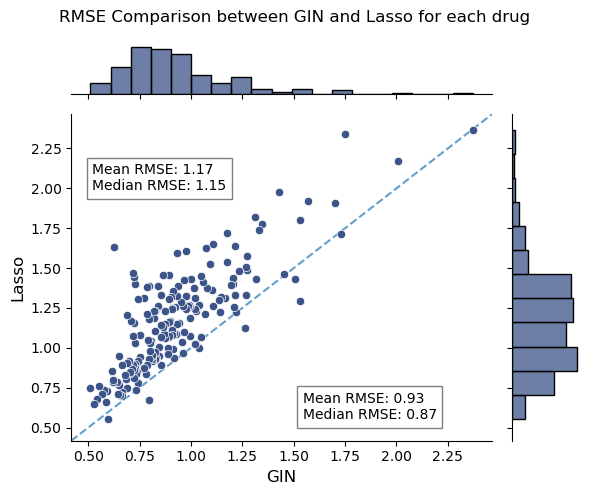

In [312]:
import seaborn as sns

combined_df['RMSE_GIN'] = pd.to_numeric(combined_df['RMSE_GIN'], errors='coerce')
combined_df['RMSE_Lasso'] = pd.to_numeric(combined_df['RMSE_Lasso'], errors='coerce')

# Drop any rows with NaN values
combined_df = combined_df.dropna(subset=['RMSE_GIN', 'RMSE_Lasso'])
joint_plot = sns.jointplot(x=combined_df['RMSE_GIN'], y=combined_df['RMSE_Lasso'], color="#3C5488FF", height= 5, ratio=5)
joint_plot.set_axis_labels("GIN", "Lasso", fontsize=12)
joint_plot.fig.set_figwidth(6)
joint_plot.fig.suptitle('RMSE Comparison between GIN and Lasso for each drug')
joint_plot.fig.tight_layout()
# Add y = x line
ax = joint_plot.ax_joint
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, '--', alpha=0.7, zorder=0)  # Red dashed line for y = x
ax.set_xlim(lims)
ax.set_ylim(lims)

# Compute Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(combined_df['RMSE_GIN'], combined_df['RMSE_Lasso'])

# Display p-value and correlation on the plot
# plt.text(0.05, 0.95, f'Pearson r: {correlation:.2f} \n p-value: {p_value:.2e}',
#          transform=ax.transAxes, verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
## Display the mean and median RMSE for Lasso
mean_rmse_lasso = combined_df['RMSE_Lasso'].mean()
median_rmse_lasso = combined_df['RMSE_Lasso'].median()
plt.text(0.05, 0.85, f'Mean RMSE: {mean_rmse_lasso:.2f} \nMedian RMSE: {median_rmse_lasso:.2f}',
         transform=ax.transAxes, verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
mean_rmse_gin = combined_df['RMSE_GIN'].mean()
median_rmse_gin = combined_df['RMSE_GIN'].median()
plt.text(0.55, 0.15, f'Mean RMSE: {mean_rmse_gin:.2f} \nMedian RMSE: {median_rmse_gin:.2f}',
         transform=ax.transAxes, verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))


## 6. Conclusion

In this notebook, we explored the application of Graph Neural Networks (GNNs) for drug response prediction, focusing on predicting IC50 values across various cancer cell lines. Through the integration of molecular graphs (representing drugs) and gene expression data (representing cancer cell lines), we demonstrated the effectiveness of GNN-based models in capturing complex relationships between drug structure and cancer cell behavior.

### Key takeaways from this notebook include:

1. **Data Processing**: We processed the GDSC2 dataset, combining drug features (derived from SMILES) and cancer cell line features (derived from gene expression data) to build a robust dataset for drug response prediction.
   
2. **Model Training**: We trained a Graph Neural Network (GNN) model to predict the drug response (IC50 values) for different cancer cell lines. By treating each drug as a graph, the GNN was able to learn intricate molecular relationships that influence drug efficacy.

3. **Baseline Comparison**: The GNN model's performance was compared to a baseline model (Lasso regression). The GNN outperformed Lasso in terms of key metrics such as RMSE and R², demonstrating its superior ability to model the interactions between drugs and cell lines.

4. **Model Evaluation**: Visualizations of predicted vs. true IC50 values for specific cancer types showed that the GNN model provides more accurate predictions, closely matching the true drug responses.

### Performance Highlights:
- **GNN Model**: Achieved strong predictive performance by leveraging molecular graph structures, capturing complex drug-cell interactions that other linear models (such as Lasso) may miss.
- **Baseline Model**: Although Lasso is a reliable model for simpler prediction tasks, it was outperformed by the GNN model, highlighting the benefits of using deep learning models for drug response prediction.

### Conclusion:
Graph Neural Networks (GNNs) offer a powerful approach for drug response prediction, outperforming traditional models like Lasso in this task. The ability of GNNs to model molecular structures as graphs allows for a more nuanced understanding of drug efficacy, making them a promising tool in precision oncology and pharmacogenomics. This work demonstrates the potential of GNNs in drug discovery, where accurate prediction of drug response is critical for developing targeted cancer therapies.

